# Stochastic Tacking Point Estimation

In [1]:
import jax.numpy as jnp
from jax import Array
from jax import vmap, jit

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr
import matplotlib.cm as cm

import pickle

import os

from abc import ABC

from load_manifold import load_stochastic_manifold

from plotting import TackPlots
from geometry.manifolds import LorentzFinslerManifold, nEllipsoid, nSphere, T2, RiemannianNavigation, nEuclidean
from geometry.tacking import SequentialOptimizationBFGS, SequentialOptimizationADAM, GEORCE_HTacking
from geometry.geodesic import GEORCE_H, GEORCE_HStep

In [2]:
figure_path = '../figures/stochastic_tacking_estimation/'

In [3]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

In [4]:
data_path = 'tacking_local/stochastic/'
T = 1_000
N_sim = 5

In [5]:
Plots = TackPlots(font_size=25,
                  power_lim=-2.,
                  colors=['red', 'blue'],
                  linewidth = 2.5,
                  s = 500,
                  alpha = 1.0,
                 )

## Direction-Only Dependent Finsler Metrics

In [6]:
curve_name = 'direction_only' #'direction_only/' #'time_only/' #'poincarre/'
save_path = ''.join((data_path, curve_name, '/'))
    
onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]

In [7]:
file_path = ''.join((save_path, onlyfiles[0]))
with open(file_path, 'rb') as f:
    curves = pickle.load(f)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [8]:
t0, z0, zT, Malpha_expected, Mbeta_expected, tack_metrics, reverse_tack_metrics = load_stochastic_manifold(curve_name)

In [9]:
indicatrix_alpha = Malpha_expected.indicatrix(0.0, z0, N_points=100)#, grid=jnp.linspace(-5,5,1000), eps=1e-6)
indicatrix_beta = Mbeta_expected.indicatrix(0.0, z0, N_points=100)#, grid=jnp.linspace(-5,5,1000), eps=1e-6)

In [10]:
xscales = [-5.0, 5.0]
yscales = [-3.0, 9.0]

In [11]:
curves.keys()

dict_keys(['ExpectedGeodesic', 'ExpectedReverseGeodesic', 'ExpectedTacking', 'ExpectedReverseTacking', 'Geodesic0', 'ReverseGeodesic0', 'Tacking0_1', 'ReverseTacking0_1', 'Geodesic1', 'ReverseGeodesic1', 'Tacking1_1', 'ReverseTacking1_1', 'Geodesic2', 'ReverseGeodesic2', 'Tacking2_1', 'ReverseTacking2_1', 'Geodesic3', 'ReverseGeodesic3', 'Tacking3_1', 'ReverseTacking3_1', 'Geodesic4', 'ReverseGeodesic4', 'Tacking4_1', 'ReverseTacking4_1'])

In [12]:
expected_zs = curves['ExpectedGeodesic']['zs']
expected_zs_reverse = curves['ExpectedReverseGeodesic']['zs']
expected_tack_curve = curves['ExpectedTacking']['zs']
expected_reverse_tack_curve = curves['ExpectedReverseTacking']['zs']

stochastic_zs = jnp.stack([curves[f'Geodesic{i}']['zs'] for i in range(N_sim)])
stochastic_zs_reverse = jnp.stack([curves[f'ReverseGeodesic{i}']['zs'] for i in range(N_sim)])
stochastic_tack_curve = jnp.stack([curves[f'Tacking{i}_1']['zs'] for i in range(N_sim)])
stochastic_reverse_tack_curve = jnp.stack([curves[f'ReverseTacking{i}_1']['zs'] for i in range(N_sim)])

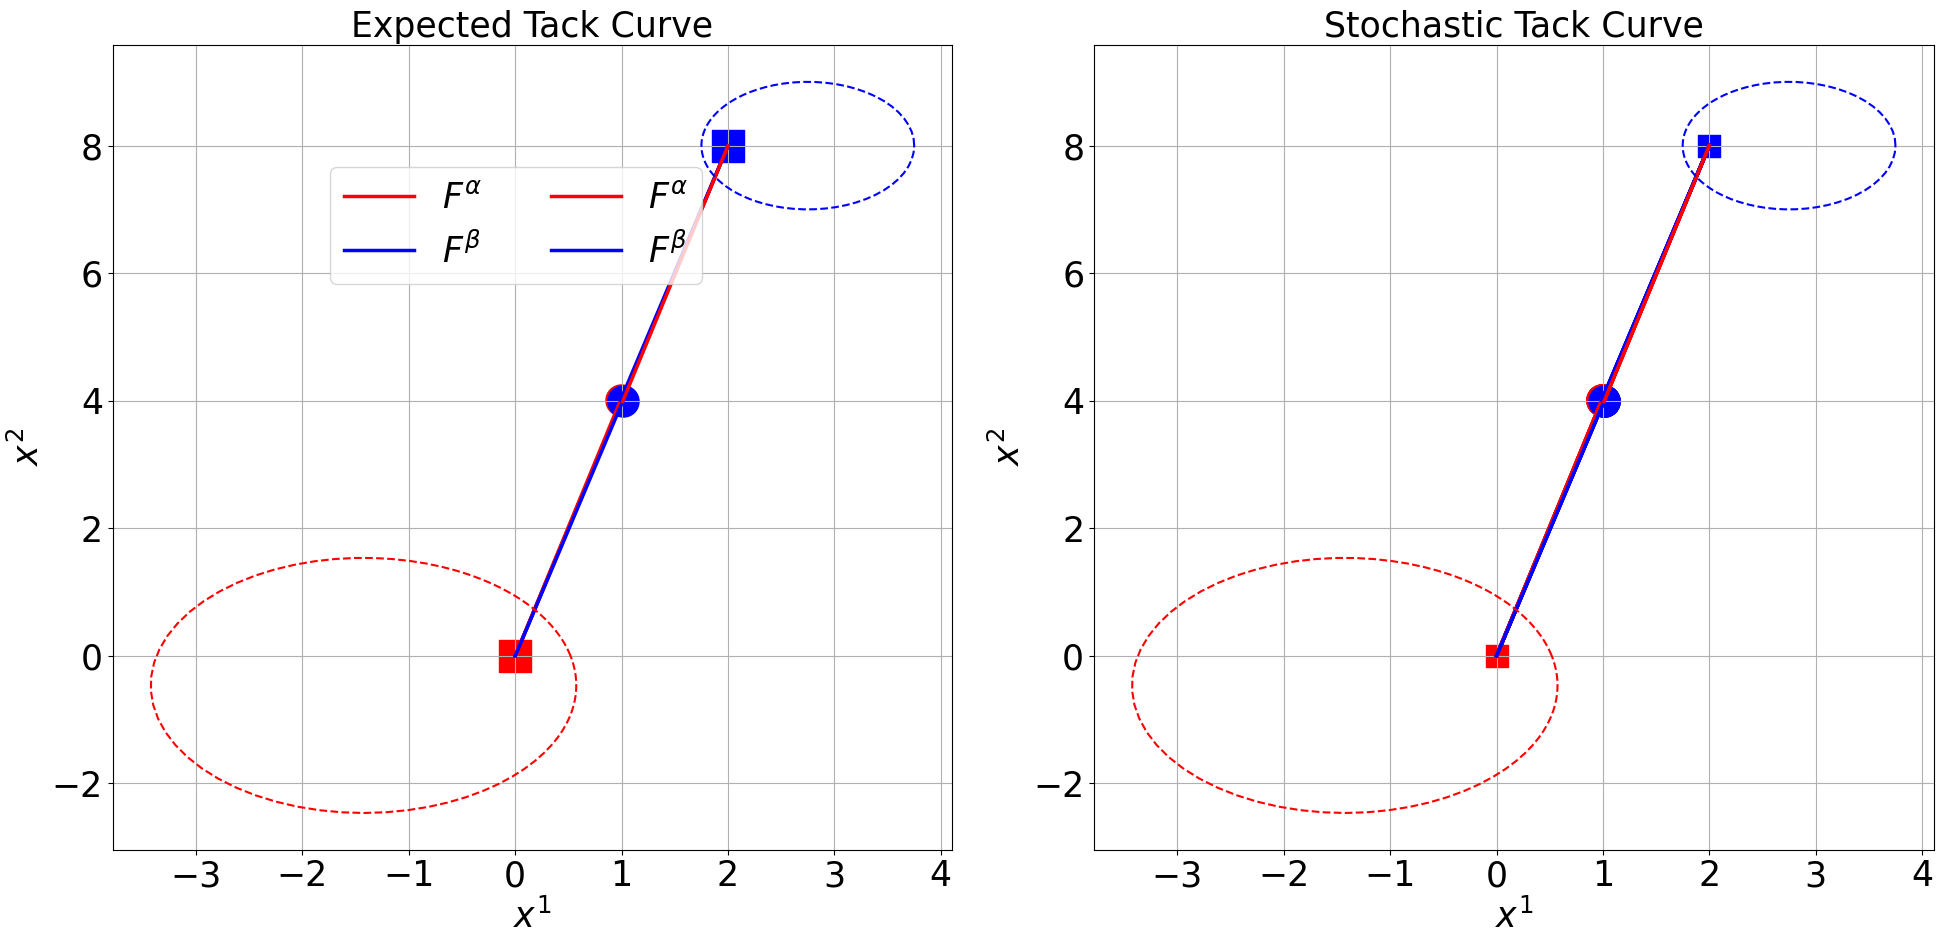

In [13]:
fig = Plots.plot_stochastic_tacking(z0,
                             zT,
                             T,
                              expected_zs,
                                expected_zs_reverse,
                                expected_tack_curve,
                                expected_reverse_tack_curve,
                                stochastic_zs,
                                stochastic_zs_reverse,
                                stochastic_tack_curve,
                                stochastic_reverse_tack_curve,
                                indicatrix_alpha=indicatrix_alpha,
                                indicatrix_beta=indicatrix_beta,
                                xscales=None,
                                yscales=None,
                                equal_frame=False,
                                save_path=f'{figure_path}stochastic_{curve_name}.pdf',
                             )

In [14]:
stochastic_zs_reverse.shape

(5, 1001, 2)